# Grafici Trasmittanza Spettrofotometro


In [1]:
import Functions_Tries.plotter as plotter
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
from Functions_Tries.transmittance import Transmittance
from pathlib import Path
import logging as lg

lg.basicConfig(filename='bog.log',filemode='w')
logger = lg.getLogger()
logger.setLevel(lg.DEBUG)


plt.style.use("seaborn")

C:\Users\ginob\AppData\Local\Temp\ipykernel_9728\2201955056.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# Il codice seguente serve al fit dello spessore dagli spettri ottenuti dallo spettrofotometro

- Usiamo la libreria ```numpy``` per avere la matematica corretta e dei contenitori efficenti.
- Usiamo la libreria ```scipy.interpolate``` per avere le curve di Bezier per interpolare i dati ottenuti dal Johnson
- Usiamo la libreria ```scipy.optimize``` per fittare gli spettri e ottenere il valore di spessore e l'errore
- Usiamo la libreria ```pandas``` per leggere i file che contengono gli spettri e per l'output
- Stefano ha scritto il modulo ```transmittance``` per avere le funzioni su cui fare il fit e per fare il primo test di fattibilità sui fit
- Usiamo il modulo ```pathlib``` per gestire i Path dei vari file in maniera automatizzata
- Usiamo la libreria ```matplotlib``` per graficare gli spettri

## TODO

- [ ] Aggiungere il salvataggio di tutti i risultati su un file
- [ ] Fare i grafici automatici, salvandoli in una cartella separata Graph

In [3]:
np.set_printoptions(precision=2)


dir = Path("./data/")
colonne = ("NomeFile","ValoreFit","ErrFit","χ^2_Rid","GdL")

NomeFile = []
ValoreFit = []
ErrFit = []
χ_2_Rid = []
GdL = []

# leggo dati del johnny
john = pd.read_csv("./data/book_data/Johnson.csv")
k_spl_john = CubicSpline(john["wl"], john["k"])
n_spl_john = CubicSpline(john["wl"], john["n"])

# Inizializziamo la classe che contiene le transmittance per i successivi fit
Trans = Transmittance(n = n_spl_john, k = k_spl_john)

# Funzione che va a fare i fit in maniera automatica a partire dai dati ottenuti
def optimizer(path):
    df=pd.read_csv(path)
    df_clean = df[df["polished"]!=0]
    filter_λ = (df_clean["lambda"] < 800e-9) & (df_clean["lambda"] > 300e-9)
    sigma = df_clean[filter_λ]["polished"] * .3/100
    popt, pcov = curve_fit(
        Trans.beer_lambert,
        df_clean[filter_λ]["lambda"],
        df_clean[filter_λ]["polished"],
        p0=60e-9,
        sigma = sigma
    )
    fig, ax = plt.subplots()
    ax.plot(df_clean[filter_λ]["lambda"]*1e9, df_clean[filter_λ]["polished"],"go", label = "original data")
    ax.plot(df_clean[filter_λ]["lambda"]*1e9, Trans.beer_lambert(df_clean[filter_λ]["lambda"], *popt), label = f"fit : {popt*1e9} nm")
    ax.set_xlabel("$\\lambda$ [nm]")
    ax.set_ylabel("Transmittance")
    ax.set_title("Fit Trasmittanza")
    ax.legend()
    fig.savefig(str(path.parent/path.stem)+".png")
    plt.clf()
    plt.cla()
    plt.close()
    chisq_rid = (np.sum(((df_clean[filter_λ]["polished"]
                     - Trans.beer_lambert(df_clean[filter_λ]["lambda"], *popt))**2 ) / sigma**2)) / df_clean.size
    return popt, np.sqrt(np.diag(pcov)), chisq_rid, df_clean.size


# Funzione che itera su tutti i file contenuti nella cartella "./data"
def iterazione(path):
    data =[i for i in path.iterdir() if i.match("*spettrofotometro")]
    for i in data:
        subfolder = [j for j in i.iterdir() if j.is_dir()]
        for folder in subfolder:
            if folder.match("ELAB"):
                for file in folder.iterdir():
                    if file.match("*.png"):
                        continue
                    if file.match("Aria*") or file.match("aria*") or file.match("air*"): 
                        continue
                    res = optimizer(file)
                    new_row = pd.Series([file, *res], index=colonne)
                    print(new_row)
                    # res_df = res_df.append(new_row, ignore_index = True)
                    # print(res_df)
                    NomeFile.append(file)
                    ValoreFit.append(float(res[0]))
                    ErrFit.append(float(res[1]))
                    χ_2_Rid.append(res[2])
                    GdL.append(res[3])
            else:
                print("La cartella non è Elab... gestiamo logica dopo")
                print(folder)
                iterazione_spettro(folder)
                
    
# In alcuni casi non si trova subito la cartella "ELAB", in quei casi bisogna scendere ancora di un livello
def iterazione_spettro(path):
    print("launching iterazione_spettro")
    print(path)
    elab = [i for i in path.iterdir() if i.match("ELAB")]
    print(elab)
    for i in elab:
        for file in i.iterdir():
            if file.match("*.png"):
                continue
            if file.match("Aria*") or file.match("aria*") or file.match("air*"): 
                continue
            res = optimizer(file)
            new_row = pd.Series([file, *res], index=colonne)
            print(new_row)
            # res_df = res_df.append(new_row, ignore_index = True)
            NomeFile.append(file)
            ValoreFit.append(float(res[0]))
            ErrFit.append(float(res[1]))
            χ_2_Rid.append(res[2])
            GdL.append(res[3])



# Finalmente lanciamo la cazzo di funzione
iterazione(dir)


res_df = pd.DataFrame(
    {
        colonne[0] : NomeFile,
        colonne[1] : ValoreFit ,
        colonne[2] : ErrFit,
        colonne[3] : χ_2_Rid,
        colonne[4] : GdL,
    }
)

res_df.to_csv("Risultati.csv", index = False)
   

NomeFile     data\12-05_spettrofotometro\ELAB\AU-Vetro_1-cm...
ValoreFit                             [1.0178970253440899e-07]
ErrFit                                [4.3219902608652176e-10]
χ^2_Rid                                           13415.586738
GdL                                                       3303
dtype: object
NomeFile     data\12-05_spettrofotometro\ELAB\AU-Vetro_2-cm...
ValoreFit                              [7.996441229502739e-08]
ErrFit                                [2.4711806116503965e-10]
χ^2_Rid                                            6087.139213
GdL                                                       3303
dtype: object
NomeFile     data\12-05_spettrofotometro\ELAB\AU-Vetro_4-cm...
ValoreFit                             [2.9050457922062483e-08]
ErrFit                                 [3.320035968218913e-11]
χ^2_Rid                                             121.378578
GdL                                                       3303
dtype: object
NomeFile     

,lambda,transmittance,polished,sigma
0,9.000000e-07,1.0173,1.109863,0.003330
1,8.995000e-07,-2.2075,-2.237255,-0.006712
2,8.990000e-07,0.0890,0.086416,0.000259
3,8.985000e-07,6.7796,9.197667,0.027593
4,8.980000e-07,-12.8027,-12.954265,-0.038863
...,...,...,...,...
1096,3.520000e-07,-0.6165,-0.528504,-0.001586
1097,3.515000e-07,0.1903,0.163292,0.000490
1098,3.510000e-07,2.2298,1.911203,0.005734
1099,3.505000e-07,-0.8535,-0.730424,-0.002191


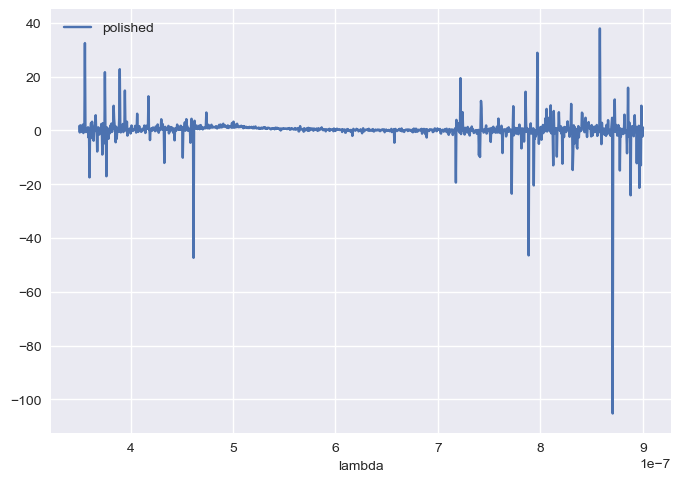

In [ ]:
data_broken = pd.read_csv("data/5-05_spettrofotometro/vetrino1_spettrofotometro/ELAB/vetroAU-vetro_1_1.csv")
data_broken.plot("lambda", "polished")
data_broken["sigma"] = data_broken["polished"] * .3/100
data_broken[data_broken["polished"]!=0]